# SNN to detect HFOs in iEEG data

In [9]:
import os, sys
import glob
import zipfile
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

# import slayer from lava-dl
import lava.lib.dl.slayer as slayer

import IPython.display as display
from matplotlib import animation

# Adjust the Working Directory

In [18]:
# Print current Working Directory
print(os.getcwd())

# Check if the current WD is the file location
if "lava-dl/src/hfo" not in os.getcwd():
    # Set working directory to this file location
    file_location = f"{os.getcwd()}/lava-dl/src/hfo/"
    print("File Location: ", file_location)

    # Change the current working Directory
    os.chdir(file_location)

    # New Working Directory
    print("New Working Directory: ", os.getcwd())

/home/monkin/Desktop/feup/thesis/lava-dl/src/hfo


# Check if GPU is Available

In [19]:
# Check if GPU is available
print(torch.cuda.is_available())

print(torch.cuda.device_count())

True
1


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [20]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    @file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=True)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

Since the `lava-dl` package has a symbolic link to the `lava` package, we can use the `utils` module from the `lava` package directly

In [26]:
from utils.input import read_spike_events

# Call the function to read the spike events
ripple_up_spike_train_file = "./data/ripple_up_spike_train_5.csv"
ripple_down_spike_train_file = "./data/ripple_down_spike_train_-5.csv"
ripple_spike_train_up = read_spike_events(ripple_up_spike_train_file)
ripple_spike_train_down = read_spike_events(ripple_down_spike_train_file)

print("Spike Train UP events: ", ripple_spike_train_up.shape, ripple_spike_train_up[:10])
print("Spike Train DOWN events: ", ripple_spike_train_down.shape, ripple_spike_train_down[:10])

Spike Train UP events:  (307, 2) [[ 4153.3203125     63.        ]
 [ 4155.76171875    63.        ]
 [ 4165.52734375    63.        ]
 [ 7249.0234375     63.        ]
 [ 7272.4609375     63.        ]
 [ 7273.92578125    63.        ]
 [ 7285.15625       63.        ]
 [ 7286.62109375    63.        ]
 [13386.23046875    63.        ]
 [13397.4609375     63.        ]]
Spike Train DOWN events:  (309, 2) [[ 4148.92578125    63.        ]
 [ 4158.69140625    63.        ]
 [ 4160.64453125    63.        ]
 [ 7242.67578125    63.        ]
 [ 7266.6015625     63.        ]
 [ 7278.80859375    63.        ]
 [ 7280.2734375     63.        ]
 [ 7291.015625      63.        ]
 [13382.8125        63.        ]
 [13393.5546875     63.        ]]


# Create Dataset

The dataset class follows standard torch dataset definition. They are defined in `nmnist.py`. We will just import the dataset and augmentation routine here.

In [14]:
from nmnist import augment, NMNISTDataset

ModuleNotFoundError: No module named 'nmnist'

# Create Network

A slayer network definition follows standard PyTorch way using `torch.nn.Module`.

The network can be described with a combination of individual `synapse`, `dendrite`, `neuron` and `axon` components. For rapid and easy development, slayer provides __block interface__ - `slayer.block` - which bundles all these individual components into a single unit. These blocks can be cascaded to build a network easily. The block interface provides additional utilities for normalization (weight and neuron), dropout, gradient monitoring and network export.

In the example below, `slayer.block.cuba` is illustrated.

In [ ]:
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        neuron_params = {
                'threshold'     : 1.25,
                'current_decay' : 0.25,
                'voltage_decay' : 0.03,
                'tau_grad'      : 0.03,
                'scale_grad'    : 3,
                'requires_grad' : True,     
            }
        neuron_params_drop = {**neuron_params, 'dropout' : slayer.neuron.Dropout(p=0.05),}
        
        self.blocks = torch.nn.ModuleList([
                slayer.block.cuba.Dense(neuron_params_drop, 34*34*2, 512, weight_norm=True, delay=True),    # Input of 34*34*2 and output of 512
                slayer.block.cuba.Dense(neuron_params_drop, 512, 512, weight_norm=True, delay=True),
                slayer.block.cuba.Dense(neuron_params, 512, 10, weight_norm=True),
            ])
    
    def forward(self, spike):
        for block in self.blocks:
            spike = block(spike)
        return spike
    
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad

    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

# Instantiate Network, Optimizer, DataSet and DataLoader

Running the network in GPU is as simple as selecting `torch.device('cuda')`.

In [ ]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cpu')
# device = torch.device('cuda') 

net = Network().to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

training_set = NMNISTDataset(train=True, transform=augment)
testing_set  = NMNISTDataset(train=False)

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)


NMNIST dataset is freely available here:
https://www.garrickorchard.com/datasets/n-mnist

(c) Creative Commons:
    Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.
    "Converting Static Image Datasets to Spiking Neuromorphic Datasets Using
    Saccades",
    Frontiers in Neuroscience, vol.9, no.437, Oct. 2015



# Visualize the input data

A `slayer.io.Event` can be visualized by invoking it's `Event.show()` routine. `Event.anim()` instead returns the event visualization animation which can be embedded in notebook or exported as video/gif. Here, we will export gif animation and visualize it.

In [ ]:
for i in range(5):
    spike_tensor, label = testing_set[np.random.randint(len(testing_set))]

    # reshape the 2D tensor to the shape (sign_event, height_img, width_img, num_time_bins) to separate the events of each timestamp
    spike_tensor = spike_tensor.reshape(2, 34, 34, -1)  
    
    event = slayer.io.tensor_to_event(spike_tensor.cpu().data.numpy())
    anim = event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    anim.save(f'gifs/input{i}.gif', animation.PillowWriter(fps=24), dpi=300)

In [ ]:
gif_td = lambda gif: f'<td> <img src="{gif}" alt="Drawing" style="height: 250px;"/> </td>'
header = '<table><tr>'
images = ' '.join([gif_td(f'gifs/input{i}.gif') for i in range(5)])
footer = '</tr></table>'
display.HTML(header + images + footer)

,,,,


# Error module

Slayer provides prebuilt loss modules: `slayer.loss.{SpikeTime, SpikeRate, SpikeMax}`.
* `SpikeTime`: precise spike time based loss when target spike train is known.
* `SpikeRate`: spike rate based loss when desired rate of the output neuron is known.
* `SpikeMax`: negative log likelihood losses for classification without any rate tuning.

Since the target spike train is not known for this problem, we use `SpikeRate` loss and target high spiking rate for true class and low spiking rate for false class.

target rate: $\hat{\boldsymbol r} = r_\text{true}\,{\bf 1}[\text{label}] + r_\text{false}\,(1-{\bf 1}[\text{label}])$ where ${\bf 1}[\text{label}]$ is one-hot encoding of label. The loss is:

$$L = \frac{1}{2} \left(\frac{1}{T}\int_T {\boldsymbol s}(t)\,\text dt -  \hat{\boldsymbol r}\right)^\top {\bf 1}$$

In [ ]:
error = slayer.loss.SpikeRate(true_rate=0.2, false_rate=0.03, reduction='sum').to(device)

# Stats and Assistants

Slayer provides `slayer.utils.LearningStats` as a simple learning statistics logger for training, validation and testing.

In addtion, `slayer.utils.Assistant` module wraps common training validation and testing routine which help simplify the training routine.

In [ ]:
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(net, error, optimizer, stats, classifier=slayer.classifier.Rate.predict)

# Training Loop

Training loop mainly consists of looping over epochs and calling `assistant.train` and `assistant.test` utilities over training and testing dataset. The `assistant` utility takes care of statndard backpropagation procedure internally.

* `stats` can be used in print statement to get formatted stats printout.
* `stats.testing.best_accuracy` can be used to find out if the current iteration has the best testing accuracy. Here, we use it to save the best model.
* `stats.update()` updates the stats collected for the epoch.
* `stats.save` saves the stats in files.

In [ ]:
# epochs = 100
epochs = 1

for epoch in range(epochs):
    for i, (input, label) in enumerate(train_loader): # training loop
        output = assistant.train(input, label)
        print(f"Training epoch {i}/{len(train_loader)}", end="\r")
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    for i, (input, label) in enumerate(test_loader): # training loop
        output = assistant.test(input, label)
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
        
    if epoch%20 == 19: # cleanup display
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}] {stats}'))
        stats_str = str(stats).replace("| ", "\n")
        print(f'[Epoch {epoch:2d}/{epochs}]\n{stats_str}')
    
    if stats.testing.best_accuracy:
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    net.grad_flow(trained_folder + '/')

KeyboardInterrupt: 

# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


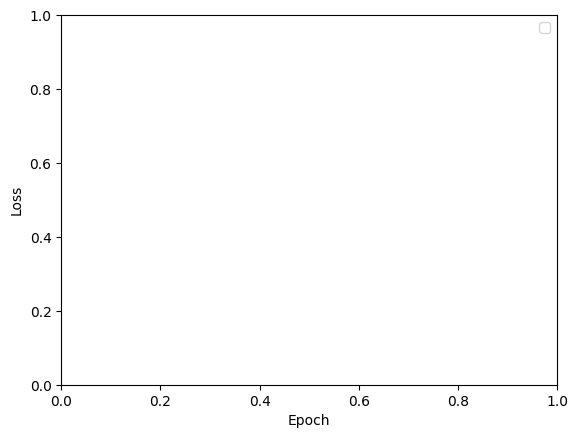

In [ ]:
stats.plot(figsize=(15, 5))

# Export the best model

Load the best model during training and export it as hdf5 network. It is supported by `lava.lib.dl.netx` to automatically load the network as a lava process.

In [ ]:
if torch.cuda.is_available():
    net.load_state_dict(torch.load(trained_folder + '/network.pt'))
else:
    net.load_state_dict(torch.load(trained_folder + '/network.pt', map_location=torch.device('cpu')))


net.export_hdf5(trained_folder + '/network.net')

# Visualize the network output

Here, we will use `slayer.io.tensor_to_event` method to convert the torch output spike tensor into `slayer.io.Event` object and visualize a few input and output event pairs.

In [ ]:
output = net(input.to(device))
for i in range(5):
    # Reshape the input to the shape (sign_event, height_img, width_img, num_time_bins) to separate each DVS event
    inp_event = slayer.io.tensor_to_event(input[i].cpu().data.numpy().reshape(2, 34, 34, -1))

    # Reshape the output to a list containing the prediction percentage of each class
    out_event = slayer.io.tensor_to_event(output[i].cpu().data.numpy().reshape(1, 10, -1))

    inp_anim = inp_event.anim(plt.figure(figsize=(5, 5)), frame_rate=240)
    out_anim = out_event.anim(plt.figure(figsize=(10, 5)), frame_rate=240)
    inp_anim.save(f'gifs/inp{i}.gif', animation.PillowWriter(fps=24), dpi=300)
    out_anim.save(f'gifs/out{i}.gif', animation.PillowWriter(fps=24), dpi=300)


In [ ]:
html = '<table>'
html += '<tr><td align="center"><b>Input</b></td><td><b>Output</b></td></tr>'
for i in range(5):
    html += '<tr>'
    html += gif_td(f'gifs/inp{i}.gif')
    html += gif_td(f'gifs/out{i}.gif')
    html += '</tr>'
html += '</tr></table>'
display.HTML(html)

Input,Output
,
,
,
,
,
